# Предобработка медицинских документов

Проект выполнен:
- Константином Самолиновым (@noran_msk);
- Татьяной Соломиной (@tatvenger).

## Описание проекта

**Общая информация**\
Заказчик - DonorSearch -  занимается развитием донорства в стране. Для этого есть платформа DonorSearch.org, где для доноров доступны бонусная программа, игрофикация пути донора и многое другое. Важной является проверка честности доноров и корректности внесенных донаций. Подтверждение производится по справке установленной формы (№405), такую справку донор получает в центре крови.  Далее загружает как картинку или pdf в личный кабинет. Раньше операторами платформы все донации верифицировались вручную. В 2023 году участниками Акселерации Мастерской данных Яндекс-Практикума  был разработан сервис OCR (optical character recognition) для распознавания табличной информации на бланке справки и записи результатов в .csv файл. Существующая версия сервиса требует вертикальной ориентации справки, однако с точки зрения удобства пользователя хотелось бы обрабатывать справки независимо от их ориентации.

**Цель проекта** \
Необходимо разработать модель компьютерного зрения, которая определяет ориентацию справки в одном из четырех форматов (0°, 90°, 180° или 270°) и автоматически поворачивает ее в нормальное положение перед запуском сервиса OCR.

**Описание данных**\
Заказчиком предоставлены изображения справок формы №405, принтскринов страниц с Портала Госсуслуги из раздела "Донорство крови и ее компонентов" и прочих форм справок о сдаче крови донором.

**План работ**
- Исследование существующих подходов к решению задачи.
- Разработка модели компьютерного зрения для определения ориентации изображения.
- Тестирование модели, определение метрик.
- Подготовка скриптов для препроцессинга изображения, инференса модели и постпроцессинга изображения.
- Создание микросервиса для последующей интеграции в продукт заказчика.

Все вышеуказанные этапы, кроме двух последних, реализованы в рамках этого документа. Два последних этапа реализованы c помощью FastApi и Docker.

## Исследование существующих подходов к решению задачи

Если переводить поставленную перед нами задачу на язык машинного обучения, то нам требуется построение модели, предсказывающей угол ориентации медицинской справки по форме № 405 - такая задача представляет собой задачу классификации. Поскольку мы будем работать с изображениями, то это задача из области компьютерного зрения.

Так как после разворота справки в правильной ориентации она будет передаваться в сервис распознавания текста (OCR), задачу можно переформулировать следующим образом: построение модели, которая определяет ориентацию текста на изображении медицинской справки.

Мы проанализировали статьи в Интернете на предмет возможных методов для решения этой задачи. Современные подходы к определению ориентации текста (0°, 90°, 180° или 270°) можно разделить на несколько категорий: традиционные методы компьютерного зрения и методы, основанные на глубоких нейронных сетях. Вот основные подходы:
1.  **Традиционные методы компьютерного зрения**: эти методы обычно используют классические алгоритмы для анализа изображения и определения его ориентации. Примеры таких методов:
    - Hough Transform: этот метод из библиотеки OpenCV применяется для поиска линий в изображении. Если изображение содержит текст, ориентированный под углом, Hough Transform может помочь найти доминирующие направления и определить ориентацию текста. \
    Материалы о методе:
        - https://en.wikipedia.org/wiki/Hough_transform
        - https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html#houghlinesp
        - https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/hough_lines/hough_lines.html#hough-lines
    - Tesseract OSD (Orientation and Script Detection): Tesseract OCR имеет встроенный инструмент для определения ориентации текста. Команда image_to_osd() анализирует изображение и возвращает информацию о его угле поворота.
    Материалы о методе:
        - https://pyimagesearch.com/2022/01/31/correcting-text-orientation-with-tesseract-and-python/
2. **Методы на основе глубокого обучения (Deep Learning)**: эти методы более мощные и гибкие, особенно для сложных и зашумленных изображений:
    - Сверточные нейронные сети (CNN): можно построить свою собственную CNN или использовать уже созданные архитектуры (ResNet, VCG, MobileNet, Efficient Net, Inception  и прочие) с модификацией их под нашу задачу.
    Материалы о методе:
        - https://mbassijaphet.github.io/pytorch-for-information-extraction/orientation-module/
        - https://github.com/d4nst/RotNet

    - Vision Transformers (ViT): ViT используют механизм внимания (attention) для анализа изображений. Современные подходы, такие как Vision Transformer, обучаются предсказывать ориентацию изображения на основе глобальных и локальных признаков.
    Материалы о методе:
        - https://github.com/pidahbus/deep-image-orientation-angle-detection
3. **Комбинированные подходы**: часто применяют комбинацию традиционных методов и глубокого обучения. Например, сначала с помощью классических методов (таких как Hough Transform) можно извлечь грубые признаки ориентации текста, а затем уточнить результат с помощью CNN или другой глубокой модели.

Исходя из закрепленных в ТЗ требований относительно стека технологий, мы приняли решение для выполнения цели проекта использовать методы на основе глубого обучения, а именно использовать сверточные нейронные сети. Если мы получим модели низкого качества, мы попробуем использовать комбинированный подход с преварительным извлечением признаков ориентации текста (например, линии текста) и последующим применением модели глубокого обучения.





## Импорт необходимых библиотек

In [1]:
# !pip install tqdm -q
# !pip install numpy -q
# !pip install pandas -q
# !pip install matplotlib -q
# !pip install torch -q
# !pip install torchvision -q
# !pip install pillow -q

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

from PIL import Image

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, models
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
import seaborn as sns

import torchvision.models as mdls
from torchvision.models import resnet50, ResNet50_Weights, inception_v3, Inception_V3_Weights
import torch.optim as optim
from torch.optim import lr_scheduler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Выбор процессора
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {DEVICE} device")

Using cuda device


In [4]:
# Задаем путь к папке с данными
path = '/content/drive/My Drive/DonorSearch/data'

#Задаем путь к папке для результатов
outPath = '/content/drive/My Drive/DonorSearch/result/'

In [5]:
# Задаем глобальные переменные
BATCH_SIZE = 64
IMG_SIZE = 224
n_classes = 4
generator = torch.Generator().manual_seed(160891)
CLASSES = {
    "rotation_0":0,
    "rotation_90":1,
    "rotation_180":2,
    "rotation_270":3
}


labels_map = dict(zip(CLASSES.values(), CLASSES.keys()))

## Импорт данных и анализ данных

**Предварительный анализ**

Прежде чем импортировать данные мы провели их предварительный анализ и обнаружили следующее:
- датасет, предоставленный заказчиком, состоит из 173 изображений, включающих как справки по форме 405, так и иные документы по донорству крови;
- большая часть изображений ориентирована нормально (лишь часть изображений имеет иной угол разворота);
- в датасете отсутствует какая-либо разметка классов изображений, соответственно, разметку изображений необходимо выполнить нашими силами.

**Обогащение датасета**

По нашему мнению, исходного объема данных недостаточно для выполнения нашей задачи, поэтому мы решили увеличить датасет с помощью:
- обогащения исходного датасета изображениями другими медицинскими документами, имеющими похожее содержание по сравнению с изображениями исходных датасетов (таблицы, печати, подписи, рукописный текст, принскрины);
- аугментаций изображений.

Для целей обогащения датасета дополнительными изображениями мы использовали датасет медицинских рецептов, найденный на [Kaggle](https://www.kaggle.com/datasets/bokhnhl/medical-prescription-dataset?select=prescription_dataset). Данный датасет содержит 240 файлов, из которых 5 изображений представляют собой рецепты с рукописным текстом, 17 изображений - с сочетанием рукописного и печатного текста и имеющим таблицы, 95 изображений - рецепты с печатным текстом и таблицами, 124 принскринов распечатанных медицинских рецептов и рецептов в компьютерной системе. Фотографии в данном датасете сделаны на разных поверхностях, включают в себя посторонние предметы (руки, канцелярские принадлежности, компьютерную технику), что соответствует тому, как пользователи могут фотографировать справки.

Мы объединили исходный датасет с датасетом медицинских справок, удалив из последнего часть изображений с принтскринами рецептов из системы, чтобы в дальнейшем модель не отдавала им большее предпочтение. Размер объединенного датасета составил 352 изображения.

Что касается аугментаций изображений, исходя из задачи, мы несколько ограничены в наборе возможных аугментаций, так как нам необходимо сохранить возможность определения ориентации изображения. Мы решили применить наиболее естественные с нашей точки зрения аугментации:
- небольшое искажение перспективы: пользователи могут фотографировать справки, лежащими на столе, или неровно держать камеру, поэтому такая аугментация выглядит естественно;
- небольшой поворот изображения: если поворачивать изображение на на относительно небольшой угол ориентация изображения все равно должна угадываться.

**Разметка изображений**

Для упрощения процесса разметки изображений мы вручную развернули изображения в нормальную ориентацию 0° в исходном датасете (по-другому ориентированных изображений было немного). В датасете с Kaggle изображения итак были ориентированы нормально. Далее с помощью написанного нами скрипта осуществили разделение датасета на подпапки, где каждая сооответствовала одному из 4 классов ('rotation_0', 'rotation_90', 'rotation_180', 'rotation_270'), с одновременным разворотом изображений на угол, соответствующий названию папки. В итоге мы получили по 88 изображений каждого класса.

Далее с момощью другого скрипта мы разделили полученный датасет на тренировочную, валидационную и тестовую выборки в соотношении 0.6, 0.2, 0.2 таким образом, чтобы в каждом из типов выборок содержалось одинаковое количество объектов каждого класса. Если код не может разделить в равном соотношении число объектов между выборками, он учитывает заданные проценты для тренировочной и валидационной выборки, все оставшиеся изображения определяет в тестовую выборку.

В итоге мы получили следующую структуру датасета:

```
data/
├── train/
│   ├── rotation_0/
│   ├── rotation_90/
│   ├── rotation_180/
│   └── rotation_270/
├── val/
│   ├── rotation_0/
│   ├── rotation_90/
│   ├── rotation_180/
│   └── rotation_270/
└── test/
    ├── rotation_0/
    ├── rotation_90/
    ├── rotation_180/
    └── rotation_270/
```


Такая структура папок позволяет нам сразу получить принадлежность к определенной выборке и определенному классу для каждого изображения. Для простоты обработки и классификации мы решили закодировать каждый из классов следующим образом:
- названию класса "rotation_0" будет соответствовать код 0;
- названию класса "rotation_90" будет соответствовать код 1;
- названию класса "rotation_180" будет соответствовать код 2;
- названию класса "rotation_270" будет соответствовать код 3.

Перейдем непосредственно к загрузке датасета.

Как было отмечено выше, мы будем применять аугментации к датасету в виде искажения перспективы и небольшого поворота. Зададим функцию для получения словарей трансформеров. Словарь трансформеров мы определяем, так как будем рассматривать различные модели, которым на вход требуются изображения разного размера. Для искажения перспективы зададим небольшую степень искажения 0.2, поворот изображений также будем осуществлять на небольшой угол, чтобы не было несоответствия между изображением и классом. Угол поворота будет находиться в диапазоне от -5 до 5 градусов.

In [6]:
# Зададим переменные для нормализации изображений
MEAN=[0.485, 0.456, 0.406]
STD=[0.229, 0.224, 0.225]

# Создаем функцию для определения словарей трансформеров
def define_transforms(IMG_SIZE):

    # Создаем трансформеры для расширения тренировочной выборки и еe нормализации
    # Для тестовой выборки будет выполнена только трансформация

    data_transforms ={
        'train':[
            # Трансформер для нормализации тренировочной выборки
            transforms.Compose([
                transforms.Resize((IMG_SIZE,IMG_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize(MEAN, STD)
            ]),

            # Трансформер для аугментации тренировочной выборки с применением изменения перспективы
            transforms.Compose([
                transforms.Resize((IMG_SIZE,IMG_SIZE)),
                transforms.ToTensor(),
                transforms.RandomPerspective(distortion_scale=0.2, p=1),
                transforms.Normalize(MEAN, STD)
            ]),

            # Трансформер для аугментации тренировочной выборки с применением небольшого поворота в диапазоне (-5,5) градусов
            transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((IMG_SIZE,IMG_SIZE)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.Normalize(MEAN, STD)
            ])

        ],


        'val': [
            # Трансформер для нормализации валидационной выборки
            transforms.Compose([
                transforms.Resize((IMG_SIZE,IMG_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize(MEAN, STD)
            ]),

            # Трансформер для аугментации валидационной выборки с применением изменения перспективы
            transforms.Compose([
               transforms.Resize((IMG_SIZE,IMG_SIZE)),
               transforms.ToTensor(),
               transforms.RandomPerspective(distortion_scale=0.2),
               transforms.Normalize(MEAN, STD)
            ]),

            # Трансформер для аугментации валидационной выборки с применением небольшого поворота в диапазоне (-5,5) градусов
            transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((IMG_SIZE,IMG_SIZE)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.Normalize(MEAN, STD)
            ])
                ],
        # Трансформер для нормализации тестовой выборки
        'test': [transforms.Compose([
                transforms.Resize((IMG_SIZE,IMG_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize(MEAN, STD)
            ])]
    }
    return data_transforms

In [7]:
# Определим дата трансформер
data_transforms = define_transforms(IMG_SIZE)

Далее задаем класс для создания кастомного датасета, который будет по названию папки, в которой лежит изображение, определять название и код класса. Внутрь класса также зашьем возможность применения трансформаций.

In [8]:
# Задаем класс для создания датасета
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        for class_name in os.listdir(img_dir):
            class_path = os.path.join(img_dir, class_name)

            if os.path.isdir(class_path):
                label = CLASSES[class_name]
                self.class_to_idx[class_name] = label

                for image_name in os.listdir(class_path):
                    image_path = os.path.join(class_path,image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(label)


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)


        if self.target_transform:
            label = self.target_transform(label)

        return image, torch.tensor(label)


С помощью ранее заданного класса создания датасетов и словаря трансформеров, получим датасеты для тренировочной, валидационной и тестовой выборок до применения аугментаций.

In [9]:
# Создаем датасеты для train, val и test
train_dataset = ImageDataset(os.path.join(path, 'train'), transform=data_transforms['train'][0])
val_dataset = ImageDataset(os.path.join(path, 'val'), transform=data_transforms['val'][0])
test_dataset = ImageDataset(os.path.join(path, 'test'), transform=data_transforms['test'][0])

Проверим размерность полученных выборок и баланс классов внутри них. Для этого зададим функцию подсчета объектов внутри датасетов.

In [10]:
# Задаем функцию подсчета объектов в разрезе каждой выборки и каждого класса

def count_per_dataset_class(dataset, name):

    if isinstance(dataset, torch.utils.data.ConcatDataset):

        # Счетчики для каждого класса из всех датасетов
        overall_class_counts = {}
        overall_dataset_size = 0

        # Обрабатываем каждый отдельный датасет внутри ConcatDataset
        for idx, sub_dataset in enumerate(dataset.datasets):
            dataset_size = len(sub_dataset)
            overall_dataset_size += dataset_size

            # Инициализируем счетчик для каждого класса в этом под-датасете
            class_counts = {class_name: 0 for class_name in sub_dataset.class_to_idx.keys()}

            for _, label in sub_dataset:
                class_name = [name for name, idx in sub_dataset.class_to_idx.items() if idx == label.item()][0]
                class_counts[class_name] += 1

            # Выводим количество изображений для каждого класса в под-датасете
            for class_name, count in class_counts.items():
                if class_name in overall_class_counts:
                    overall_class_counts[class_name] += count
                else:
                    overall_class_counts[class_name] = count

        # Выводим общее количество изображений для всех классов в ConcatDataset
        print(f"\n  {name} dataset size: {overall_dataset_size} images")
        for class_name, count in overall_class_counts.items():
            print(f"  {class_name}: {count} images")

    else:
        # Вычисляем размеры выборки
        dataset_sizes = len(dataset)

        class_counts = {class_name: 0 for class_name in dataset.class_to_idx.keys()}

        # Проходим по всем изображениям в выборке
        for _, label in dataset:
            class_name = [name for name, idx in dataset.class_to_idx.items() if idx == label.item()][0]
            class_counts[class_name] += 1


        # Выводим количество изображений для каждого класса
        print(f"\n {name} dataset size: {dataset_sizes} images")
        for class_name, count in class_counts.items():
            print(f"  {class_name}: {count} images")

In [11]:
# Вычисляем количество объектов в каждой выборке и каждого класса до аугментаций
count_per_dataset_class(train_dataset, 'train')
count_per_dataset_class(val_dataset, 'val')
count_per_dataset_class(test_dataset, 'test')


 train dataset size: 208 images
  rotation_90: 52 images
  rotation_270: 52 images
  rotation_0: 52 images
  rotation_180: 52 images

 val dataset size: 68 images
  rotation_90: 17 images
  rotation_180: 17 images
  rotation_270: 17 images
  rotation_0: 17 images

 test dataset size: 76 images
  rotation_270: 19 images
  rotation_180: 19 images
  rotation_90: 19 images
  rotation_0: 19 images


Итого мы видим, что в тренировочная выборка состоит из 208 изображений, валидационная выборка - из 68 изображений, тестовая - из 76 изображений. В каждой из выборок изображения равномерно распределены по классам, т.е. дисбаланс классов отсутствует.

Создадим экземпляры датасетов с примененными аугментациями. Далее объединим исходный датасет с аугментированными.

In [12]:
# Создаем экземлпяры датасетов с аугментациями
train_dataset_augmented_1 = ImageDataset(os.path.join(path, 'train'), transform=data_transforms['train'][1])
train_dataset_augmented_2 = ImageDataset(os.path.join(path, 'train'), transform=data_transforms['train'][2])

val_dataset_augmented_1 = ImageDataset(os.path.join(path, 'val'), transform=data_transforms['val'][1])
val_dataset_augmented_2 = ImageDataset(os.path.join(path, 'val'), transform=data_transforms['val'][2])

In [13]:
# Объединим исходные выборки с аугментациями
train_dataset = ConcatDataset([train_dataset, train_dataset_augmented_1, train_dataset_augmented_2])
val_dataset = ConcatDataset([val_dataset, val_dataset_augmented_1, val_dataset_augmented_2])

In [14]:
# Проверим размеры выборок после применения агументаций
count_per_dataset_class(train_dataset, 'train')
count_per_dataset_class(val_dataset, 'val')
count_per_dataset_class(test_dataset, 'test')


  train dataset size: 624 images
  rotation_90: 156 images
  rotation_270: 156 images
  rotation_0: 156 images
  rotation_180: 156 images

  val dataset size: 204 images
  rotation_90: 51 images
  rotation_180: 51 images
  rotation_270: 51 images
  rotation_0: 51 images

 test dataset size: 76 images
  rotation_270: 19 images
  rotation_180: 19 images
  rotation_90: 19 images
  rotation_0: 19 images


После применения аугментаций объем тренировочной и валидационной выборок увеличился в 3 раза до 624 и 204 изображений соответственно. Равное соотношение объектов между классами сохраняется.

Далее создадим загрузчики данных для каждой из выборок.

In [15]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Посмотрим, каким образом выглядят изображения в полученном датасете на примере тренировочной выборки.

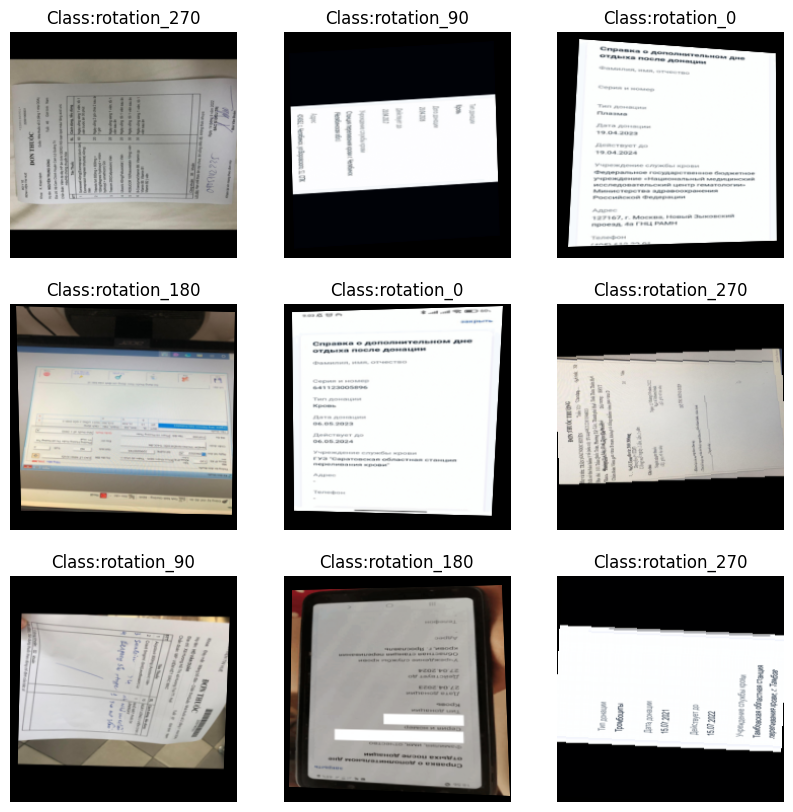

In [16]:
# Получим один батч из тренировочной выборки
look = next(iter(train_dataloader))
# Выведем примеры изображений из полученного батча
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.axis("off")
    inp = look[0][i].numpy().transpose((1,2,0))
    inp = STD * inp + MEAN
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    plt.title(f'Class:{labels_map[int(look[1][i])]}')
plt.show();

Мы видим, что изображения в полученной тренировочной выборке являются цветными. На приведенных выше изображениях правильно определены классы изображений. Мы можем видеть изображения как из оригинального датасета, так и датасета медицинских рецептов, которым мы обогатили датасет (документы не на русском языке). Также на примере нескольких изображений мы видим применные аугментации.

## Функции для обучения моделей

Зададим функции для обучения моделей. На вход в функции (в зависимости от функции) будет подаваться модель, загрузчики данных, функия потерь, оптимизатор, scheduler, а также скорость обучения. Скорость обучения мы сделаем входным параметром, чтобы имееть возможность ее регулировать вне модели.

**Выбор алгоритмов и фунции потерь**:
- функция потерь: исходя из того, что мы решаем задачу мультиклассовой классификации, подходящей функцией потерь является CrossEntropyLoss;
- оптимизатор: мы решили использовать оптимизатор Adam;
- scheduler: для возможность снижать скорость обучения после прохождения нескольких эпох.

**Выбор метрик**

В нашей задаче мультиклассовой классификации, где важно точно определить ориентацию изображения, наилучшей метрикой будет accuracy. Она измеряет долю правильно классифицированных изображений из общего числа. Поскольку классы сбалансированы, accuracy будет адекватно отражать качество модели. Она будет показывать, насколько хорошо модель предсказывает правильный класс ориентации для каждого изображения.

Также для наилучшей модели мы построим матрицу ошибок (которая поможет понять, как часто модель путает классы друг с другом, что может быть важно, если, например, модель часто путает 90 и 270 градусов) и ROC-кривую.





In [17]:
# Задаем функцию для обучения одной эпохи
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    model.train()

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    # Проходим по данным

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [18]:
# Задаем функцию для валидации одной эпохи
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [19]:
# Задаем функцию для обучения модели
def train(train_files, val_files, model, epochs, learning_rate):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss: {v_loss:0.4f} train_acc: {t_acc:0.4f} val_acc: {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()
        sch = lr_scheduler.StepLR(opt, step_size=5, gamma=0.97)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_files, criterion, opt, sch)

            val_loss, val_acc = eval_epoch(model, val_files, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [20]:
# Задаем функцию для получения предсказаний модели
def predict(model, test_loader):
    running_corrects = 0
    processed_size = 0
    with torch.no_grad():
        logits = []
        preds = []
        answers = []

        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            model.eval()
            outputs = model(inputs)
            logits.append(outputs.cpu())
            preds.append(torch.argmax(outputs, 1).cpu())
            answers.append(labels.cpu())
            running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)
            processed_size += inputs.size(0)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    preds = torch.cat(preds, dim=-1).numpy()
    answers = torch.cat(answers, dim=-1).numpy()
    test_acc = running_corrects.cpu().numpy() / processed_size
    return answers, preds, probs, test_acc

In [21]:
# Задаем функцию для визуализации результатов обучения и валидации
def visualize(history, model_name):

    train_loss, train_acc, val_loss, val_acc = zip(*history)
    # Задаем график и сетку
    fig = plt.figure(figsize=(12,9))
    fig.suptitle(model_name)
    gs = GridSpec(2, 1, height_ratios=[3, 1])

    # Добавляем график функцици потерь
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(train_loss, label='train_loss')
    ax1.plot(val_loss, label='val_loss')
    ax1.set_title('График функции потерь',y=1)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Добавлякм график accuracy
    ax2 = fig.add_subplot(gs[1])
    ax2.plot(train_acc, label='train_acc')
    ax2.plot(val_acc, label='val_acc')
    ax2.set_title('Качество модели (accuracy)',y=1)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.legend(loc='best')
    plt.show();

## Обучение моделей

В качестве первой и самой простой модели мы решили выбрать модель ResNet18. Это модель CNN глубиной в 18 слоев. Мы возьмем предобученную модель и заменим в ней только fc слой, скорректировав количество выходных классов на нужные нам 4 класса.

In [22]:
resnet = models.resnet18(pretrained=True)
num_features = 512
resnet.fc = nn.Linear(num_features, 4)
resnet = resnet.to(DEVICE)

Для начала зададим скорость обучения в размере 3e-4. Это значение зачастую используют в процессе обучения при начале работы с реальными данными.

In [23]:
lr=3e-4

Так как модель уже предобучена, у нас не такое большое количество данных и мы меняем только последний слой, попробуем обучить модель на малом количестве эпох. Возьмем 3 эпохи.

In [24]:
history = train(train_dataloader, valid_dataloader, model=resnet, epochs=3, learning_rate=lr)

epoch:  33%|███▎      | 1/3 [00:24<00:49, 24.72s/it]


Epoch 001 train_loss: 0.4225     val_loss: 0.5713 train_acc: 0.8253 val_acc: 0.8529


epoch:  67%|██████▋   | 2/3 [00:49<00:24, 24.74s/it]


Epoch 002 train_loss: 0.0127     val_loss: 0.0856 train_acc: 0.9984 val_acc: 0.9657


epoch: 100%|██████████| 3/3 [01:14<00:00, 24.68s/it]


Epoch 003 train_loss: 0.0046     val_loss: 0.0370 train_acc: 1.0000 val_acc: 0.9804


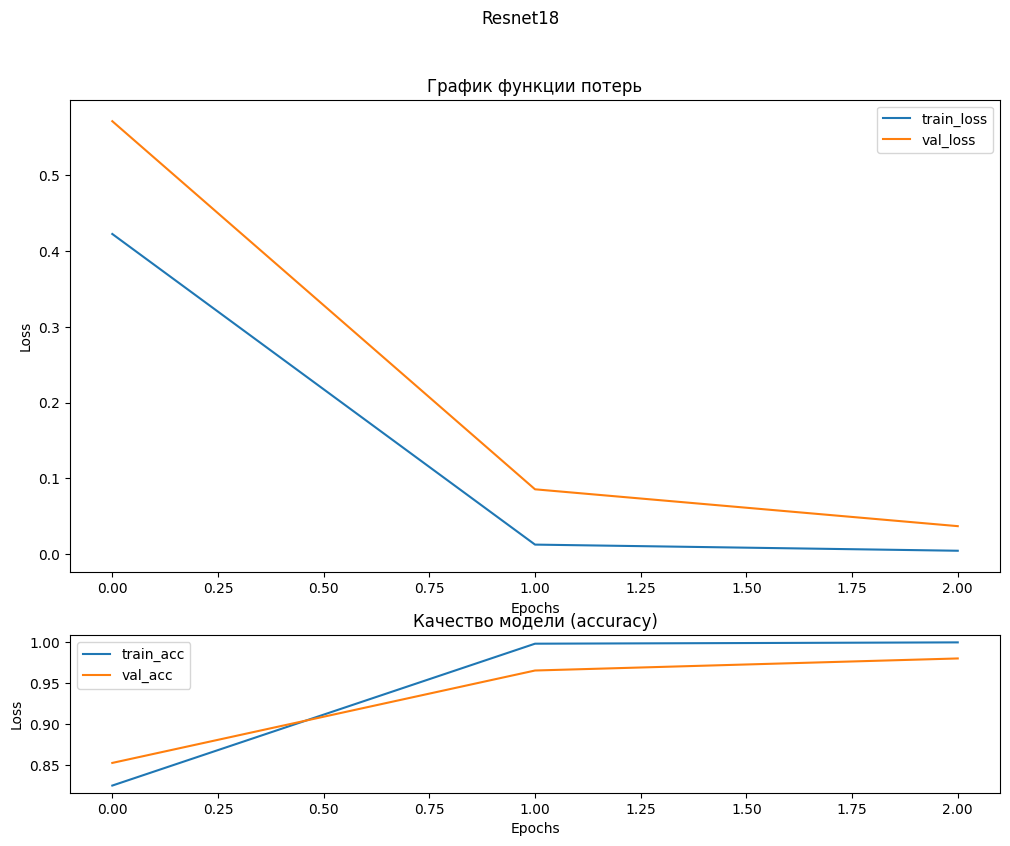

In [25]:
visualize(history, 'Resnet18')

Мы получили модель достаточно хорошего качества, которая за 3 эпохи достигла метрики accuracy=1 на тренировочной выборке, accuracy=0,98 на валидационной выборке. Мы видим достаточно ровное снижение функции потерь, без скачков. Похоже, что модель хорошо обучилась.

Далее в качестве чуть более сложной модели возьмем так же модель ResNet, но глубиной в 50 слоев. Поскольку здесь больше глубина помимо измения итогового количества классов, попробуем в предобученной модели заморозить все слои модели, кроме последних нескольких слоев.

In [26]:
# Инициализируем модель
weights = ResNet50_Weights.DEFAULT
resnet_2 = resnet50(weights=weights)

# Заморозим слои предобученной модели
for param in resnet_2.parameters():
    param.requires_grad = False

# Разморозим последние несколько слоев модели
layers = list(resnet_2.children())
for layer in layers[-4:]:
    for param in layer.parameters():
        param.requires_grad = True

resnet_2.fc = nn.Linear(resnet_2.fc.in_features, n_classes)
resnet_2 = resnet_2.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 37.9MB/s]


Для сопоставимости модель ResNet50 также обучим на 3 эпохах.

In [27]:
history_2 = train(train_dataloader, valid_dataloader, model=resnet_2, epochs=3, learning_rate=lr)

epoch:  33%|███▎      | 1/3 [00:26<00:52, 26.22s/it]


Epoch 001 train_loss: 0.9732     val_loss: 0.5112 train_acc: 0.6442 val_acc: 0.8529


epoch:  67%|██████▋   | 2/3 [00:51<00:25, 25.87s/it]


Epoch 002 train_loss: 0.1450     val_loss: 0.0577 train_acc: 0.9840 val_acc: 0.9657


epoch: 100%|██████████| 3/3 [01:17<00:00, 25.99s/it]


Epoch 003 train_loss: 0.0290     val_loss: 0.1101 train_acc: 0.9952 val_acc: 0.9559


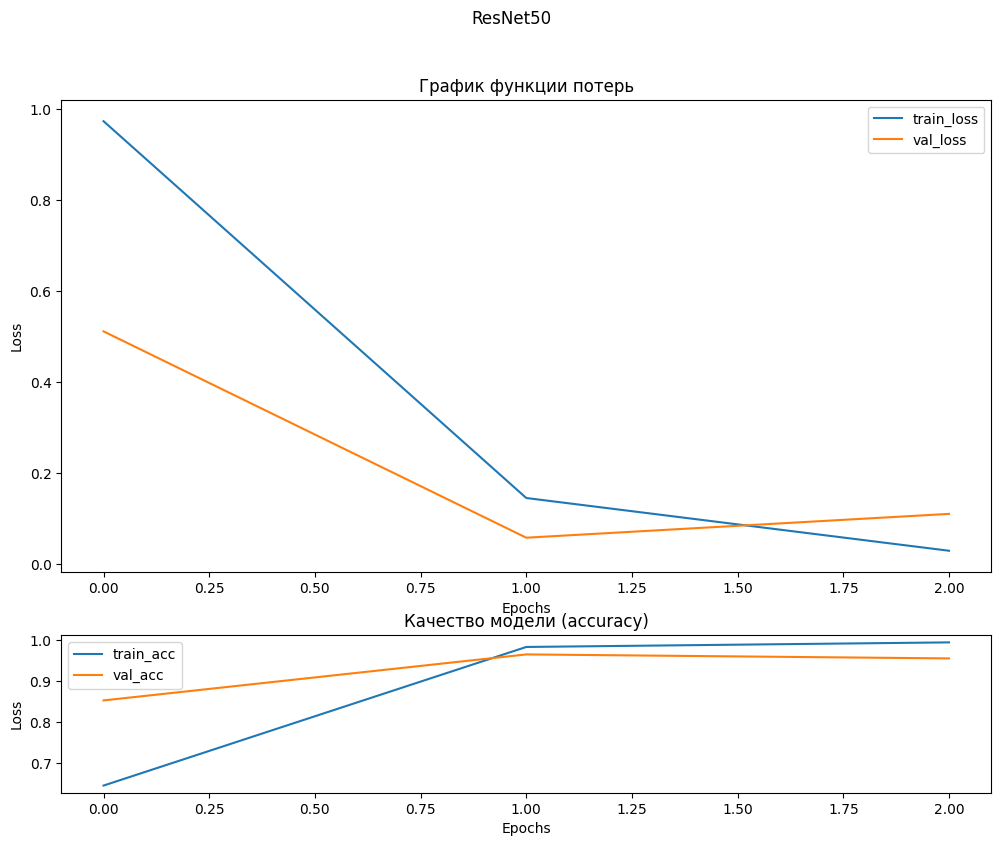

In [28]:
visualize(history_2, 'ResNet50')

 Мы можем видеть, подель слегка переобучилась на 3 эпохе. Это в целом выглядит логично, так как за счет большей глубины модели, мы получили большую сложность и большее количество признаков.

Мы применили модели архитектуры ResNet различной глубины. Попробуем использовать модель другой архитектуры. C нашей точки зрения интересной для этой задачи является архитектура модели Inception, которая создает параллельные слои. Возьмем предобученную модель Inception_v3, поменяем в ней последние слои на нужное нам количество классов и оценим ее качество. Если мы не достигнем высокого качества модели, поробуем применить иные методы файн-тьюнинга.

In [29]:
# Инициализируем модель
weights_inc = Inception_V3_Weights.IMAGENET1K_V1
inception = inception_v3(pretrained=True)

inception.AuxLogits.fc = nn.Linear(in_features=768,out_features=n_classes)
inception.fc = nn.Linear(in_features=2048, out_features=n_classes)

inception.classifier = nn.Linear(2048, 4)

inception = inception.to(DEVICE)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:03<00:00, 32.0MB/s]


Модель Inception требует на вход изображения чуть большего размера, чем мы использовали ранее (299 вместо 224). Поэтому зададим новый словарь трансформеров для нее и соответственно новый набор датасетов.

In [30]:
# Задаем размер изображения
IMG_SIZE_INC = 299
# Задаем словарь трансформеров под этот размер изображения
data_transforms_inc = define_transforms(IMG_SIZE_INC)

In [31]:
# Создаем датасеты для train, val и test для модели inception
train_dataset_inc = ImageDataset(os.path.join(path, 'train'), transform=data_transforms_inc['train'][0])
val_dataset_inc = ImageDataset(os.path.join(path, 'val'), transform=data_transforms_inc['val'][0])
test_dataset_inc = ImageDataset(os.path.join(path, 'test'), transform=data_transforms_inc['test'][0])

# Вычисляем размеры выборок до применения агументации к тестовой выборке
count_per_dataset_class(train_dataset_inc, 'train')
count_per_dataset_class(val_dataset_inc, 'val')
count_per_dataset_class(test_dataset_inc, 'test')


 train dataset size: 208 images
  rotation_90: 52 images
  rotation_270: 52 images
  rotation_0: 52 images
  rotation_180: 52 images

 val dataset size: 68 images
  rotation_90: 17 images
  rotation_180: 17 images
  rotation_270: 17 images
  rotation_0: 17 images

 test dataset size: 76 images
  rotation_270: 19 images
  rotation_180: 19 images
  rotation_90: 19 images
  rotation_0: 19 images


Мы получили датасет тех же размеров, что и ранее. Создадим датасеты с агументациями и объединим их с основным.

In [32]:
# Создаем экземлпяры датасетов с аугментациями
train_dataset_augmented_inc_1 = ImageDataset(os.path.join(path, 'train'), transform=data_transforms_inc['train'][1])
train_dataset_augmented_inc_2 = ImageDataset(os.path.join(path, 'train'), transform=data_transforms_inc['train'][2])

val_dataset_augmented_inc_1 = ImageDataset(os.path.join(path, 'val'), transform=data_transforms_inc['val'][1])
val_dataset_augmented_inc_2 = ImageDataset(os.path.join(path, 'val'), transform=data_transforms_inc['val'][2])

In [33]:
# Объединим исходные выборки с аугментациями
train_dataset_inc = ConcatDataset([train_dataset_inc, train_dataset_augmented_inc_1, train_dataset_augmented_inc_2])
val_dataset_inc = ConcatDataset([val_dataset_inc, val_dataset_augmented_inc_1, val_dataset_augmented_inc_2])

In [34]:
# Проверим размеры выборок
count_per_dataset_class(train_dataset_inc, 'train')
count_per_dataset_class(val_dataset_inc, 'val')
count_per_dataset_class(test_dataset_inc, 'test')


  train dataset size: 624 images
  rotation_90: 156 images
  rotation_270: 156 images
  rotation_0: 156 images
  rotation_180: 156 images

  val dataset size: 204 images
  rotation_90: 51 images
  rotation_180: 51 images
  rotation_270: 51 images
  rotation_0: 51 images

 test dataset size: 76 images
  rotation_270: 19 images
  rotation_180: 19 images
  rotation_90: 19 images
  rotation_0: 19 images


Здесь с размерами датасетов также все ожидаемо. Зададим загрузчики данных и обучим модель. Для начала обучим ее на 5 эпохах.

In [35]:
train_dataloader_inc = torch.utils.data.DataLoader(train_dataset_inc, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_dataloader_inc = torch.utils.data.DataLoader(val_dataset_inc, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dataloader_inc = torch.utils.data.DataLoader(test_dataset_inc, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [36]:
inception.aux_logits = False
history_3 = train(train_dataloader_inc, valid_dataloader_inc, model=inception, epochs=5, learning_rate=lr)

epoch:  20%|██        | 1/5 [00:33<02:13, 33.47s/it]


Epoch 001 train_loss: 0.7176     val_loss: 0.3892 train_acc: 0.7404 val_acc: 0.8333


epoch:  40%|████      | 2/5 [01:06<01:39, 33.30s/it]


Epoch 002 train_loss: 0.0549     val_loss: 0.1133 train_acc: 0.9952 val_acc: 0.9706


epoch:  60%|██████    | 3/5 [01:39<01:06, 33.11s/it]


Epoch 003 train_loss: 0.0053     val_loss: 0.0888 train_acc: 1.0000 val_acc: 0.9706


epoch:  80%|████████  | 4/5 [02:12<00:32, 32.92s/it]


Epoch 004 train_loss: 0.0097     val_loss: 0.2285 train_acc: 0.9968 val_acc: 0.9412


epoch: 100%|██████████| 5/5 [02:44<00:00, 32.99s/it]


Epoch 005 train_loss: 0.0187     val_loss: 0.1552 train_acc: 0.9984 val_acc: 0.9657


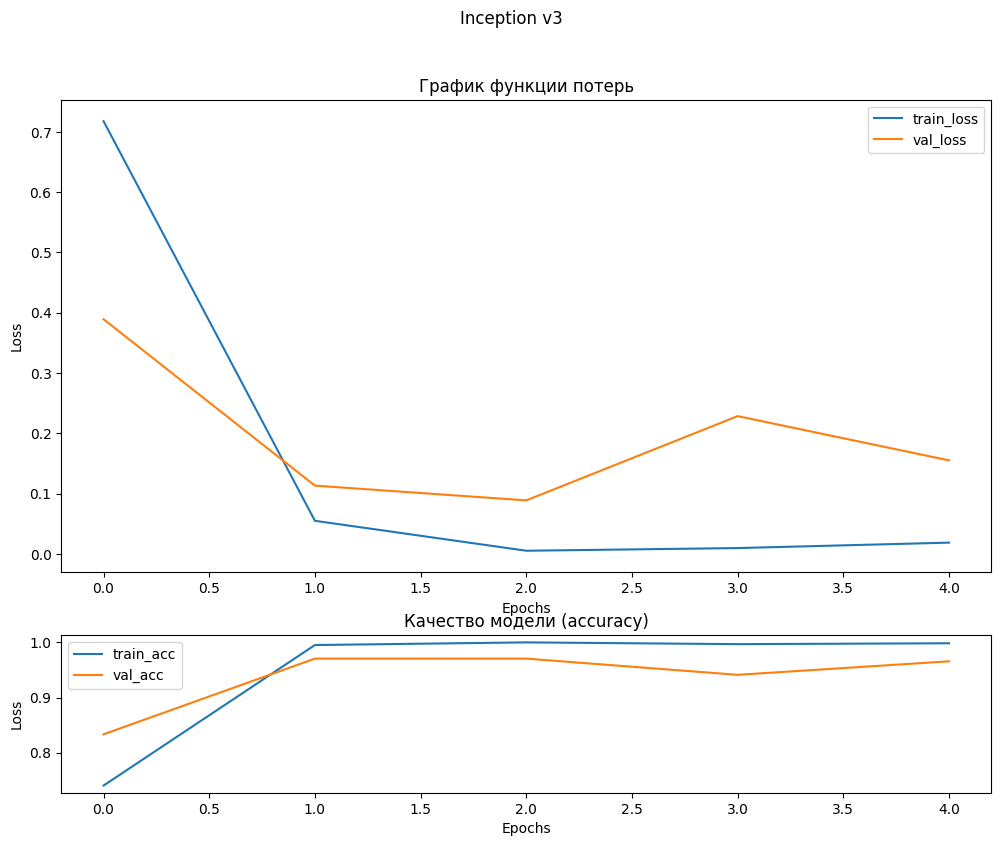

In [37]:
visualize(history_3, 'Inception v3')

Модель Inception также показала хорошее качество: метрика accuracy на тренировочной выборке составила 0.9984, а на валидационной - 0.9657. Однако создается впечатление, что последние две эпохи были лишними.  Функция потерь валидационной выборки достигла своих минимальных значений на 3 эпохе, а далее немного подскочила вверх. Попробуем обучить модель на 3 эпохах вместо 5.

In [38]:
# Инициализируем модель
weights_inc = Inception_V3_Weights.IMAGENET1K_V1
inception_2 = inception_v3(pretrained=True)

inception_2.AuxLogits.fc = nn.Linear(in_features=768,out_features=n_classes)
inception_2.fc = nn.Linear(in_features=2048, out_features=n_classes)

inception_2.classifier = nn.Linear(2048, 4)

inception_2 = inception_2.to(DEVICE)

In [39]:
inception_2.aux_logits = False
history_4 = train(train_dataloader_inc, valid_dataloader_inc, model=inception_2, epochs=3, learning_rate=lr)

epoch:  33%|███▎      | 1/3 [00:32<01:05, 32.85s/it]


Epoch 001 train_loss: 0.7514     val_loss: 0.3497 train_acc: 0.7308 val_acc: 0.8382


epoch:  67%|██████▋   | 2/3 [01:06<00:33, 33.26s/it]


Epoch 002 train_loss: 0.0768     val_loss: 0.1445 train_acc: 0.9792 val_acc: 0.9510


epoch: 100%|██████████| 3/3 [01:40<00:00, 33.47s/it]


Epoch 003 train_loss: 0.0062     val_loss: 0.0402 train_acc: 1.0000 val_acc: 0.9853


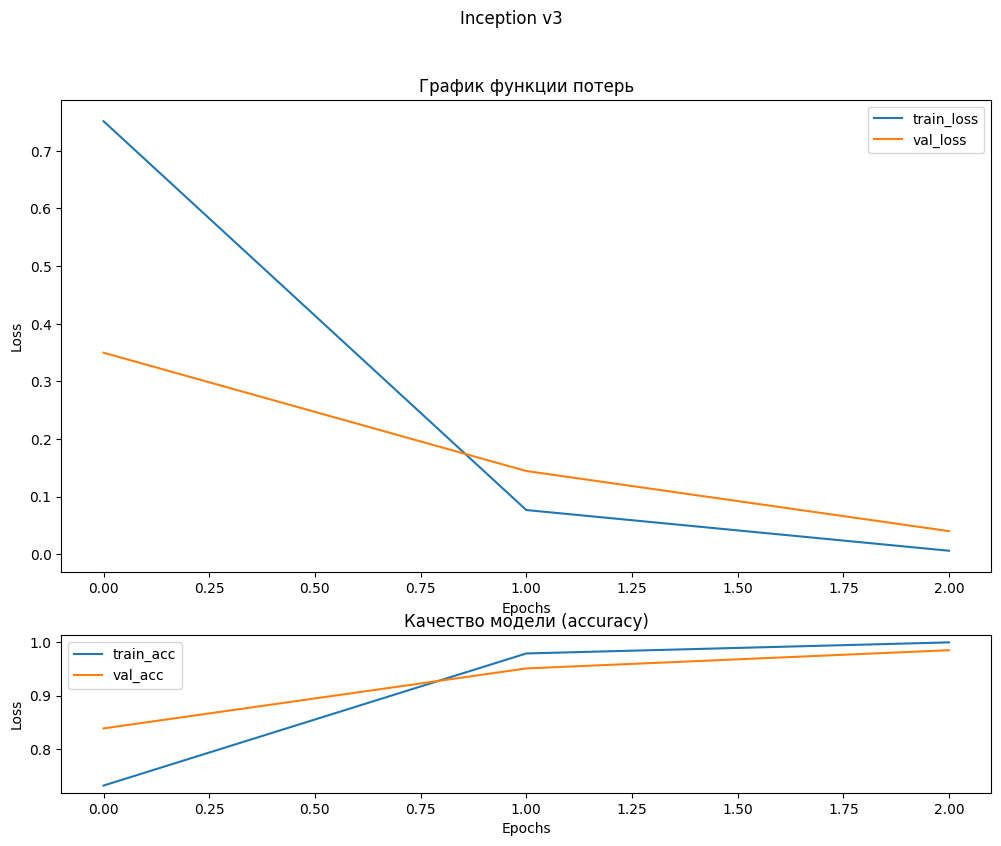

In [40]:
visualize(history_4, 'Inception v3')

Наша гипотеза оказалась верной, на 3 эпохах мы получили модель лучшего качества с плавным снижением потерь как на тренировочной, так и на валидационной выборке. Метрика accuracy достигла значения 1 на тренировочной  выборке и 0,9853 на валидационной. Поэтому остановимся на второй версии модели Inception.

## Выбор наилучшей модели

Для удобства сравнения моделей выведем метрики, полученные на обучении и валидации в одной таблице.

In [41]:
models_results = [

    {'Модель': 'ResNet18',
     'Количетсво эпох': 3,
     'Accuracy train': history[-1][1],
     'Accuracy validation': history[-1][-1]},

    {'Модель': 'ResNet50',
     'Количетсво эпох': 3,
     'Accuracy train': history_2[-1][1],
     'Accuracy validation': history_2[-1][-1]},


    {'Модель': 'Inception',
     'Количетсво эпох': 3,
     'Accuracy train': history_4[-1][1],
     'Accuracy validation': history_4[-1][-1]}

]

models_results = pd.DataFrame(models_results)

models_results

,Модель,Количетсво эпох,Accuracy train,Accuracy validation
0,ResNet18,3,1.000000,0.980392
1,ResNet50,3,0.995192,0.955882
2,Inception,3,1.000000,0.985294


Исходя из значений метрики accuracy на валидационной выборке, лучшей моделью оказалась модель Inception. Для дальнейшего рассмотрения возьмем именно эту модель.

Найдем предсказания выбранной нами модели на тестовой выборке, а также вычислим значение accuracy.

In [42]:
result = predict(inception_2, test_dataloader_inc)
print(f'Test Accuracy for Inception -- {result[3]:.2}')

Test Accuracy for Inception -- 0.96


Значением метрики accuracy выбранной модели на тестовой выборке снизилось по сравнению с валидационной: на валидационной выборке accuracy=0,985, на тестовой выборке accuracy=0.96.

Выведем реальные и предсказанные метки классов изображений.

In [43]:
classes_true = result[0]
classes_pred = result[1]

print('Реальные классы ориентации изображений:')
print(classes_true)
print('Предсказанные классы ориентации изобрежений')
print(classes_pred)

Реальные классы ориентации изображений:
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
Предсказанные классы ориентации изобрежений
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 1 3 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


Далее построим матрицу ошибок, которая поможет нам лучше понять, где допустила ошибки наша модель.

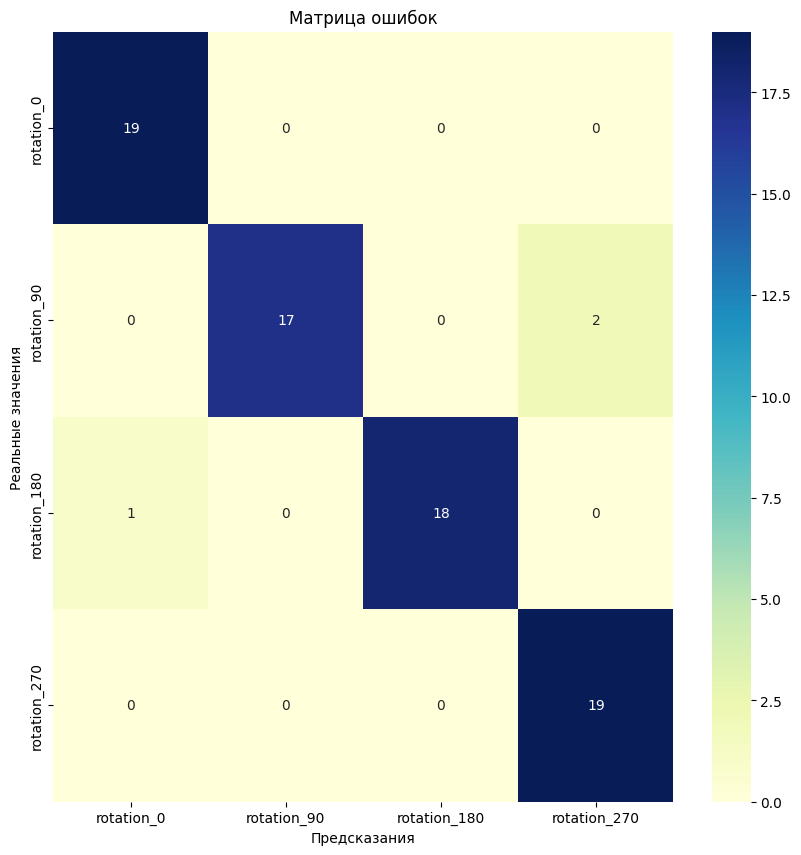

In [44]:
# Создаем датафрейм для матрицы ошибок
conf_mx = pd.DataFrame(confusion_matrix(classes_true, classes_pred, labels=list(CLASSES.values())))

# Визуализируем матрицу ошибок
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mx, annot= True , fmt="d",  cmap='YlGnBu', ax=ax)

ax.set_title('Матрица ошибок');
ax.set_xlabel('Предсказания')
ax.set_ylabel('Реальные значения');


ax.xaxis.set_ticklabels(CLASSES.keys())
ax.yaxis.set_ticklabels(CLASSES.keys())
plt.show()

Мы можем видеть, что из 76 тестовых изображений модель допустила 3 ошибки, ориентация остальных изображений была определена корректно:
- два изображения с оригинальной ориентацией 90 градусов были определено как изображения с ориентацией 270 градусов;
- одно изображение с ориентацией 180 градусов было определено как изображение с ориентацией 0 градусов.
Обе ошибки достаточно близки к реальности: изображения с ориентацией 0 градусов и 180 градусов и ориентацией 90 и 270 градусов действительно можно спутать. 

Мы также можем видеть, что модель хорошо научилась предсказывать ориентацию изображений для изображений c ориентацией 0 градусов и с ориентаций 270 градусов.

Посмотрим на изображения, в которых модель допустила ошибки в определении класса.


In [45]:
# Найдем некорректно классифицированные изображения
filter = list(classes_true != classes_pred)
errors = [x for x,y in zip(test_dataset_inc.image_paths, filter) if y== True]

In [46]:
errors_true_class = classes_true[(classes_true != classes_pred)]

In [47]:
errors_pred_class = classes_pred[(classes_true != classes_pred)]

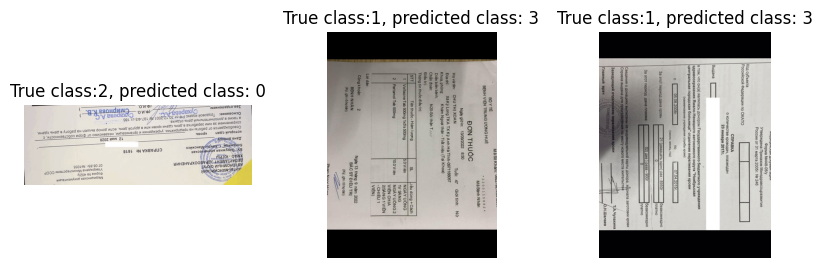

In [48]:
# Выведем некорректно классифицированные изображения
plt.figure(figsize=(10, 10))
for i in range(len(errors)):
    plt.subplot(3, 3, i+1)
    plt.axis("off")
    err_img = Image.open(errors[i]).convert('RGB')
    array = np.array(err_img)
    plt.imshow(err_img)
    plt.title(i)
    plt.title(f'True class:{errors_true_class[i]}, predicted class: {errors_pred_class[i]}')
plt.show();

Действительно мы можем видеть, что одна справка явно ориентированная на 180 градусов (метка класса=2), была определена как справка в нормальной ориентации(метка класса=0), а два изображения с ориентацией на 90 градусов (метка класса=1) классифицированы как изображения с ориентацией 270 градусов (метка класса=3).

Далее построим ROC-кривые для выбранной модели в разрезе каждого класса. Одновременно рассчитаем метрику ROC_AUC.

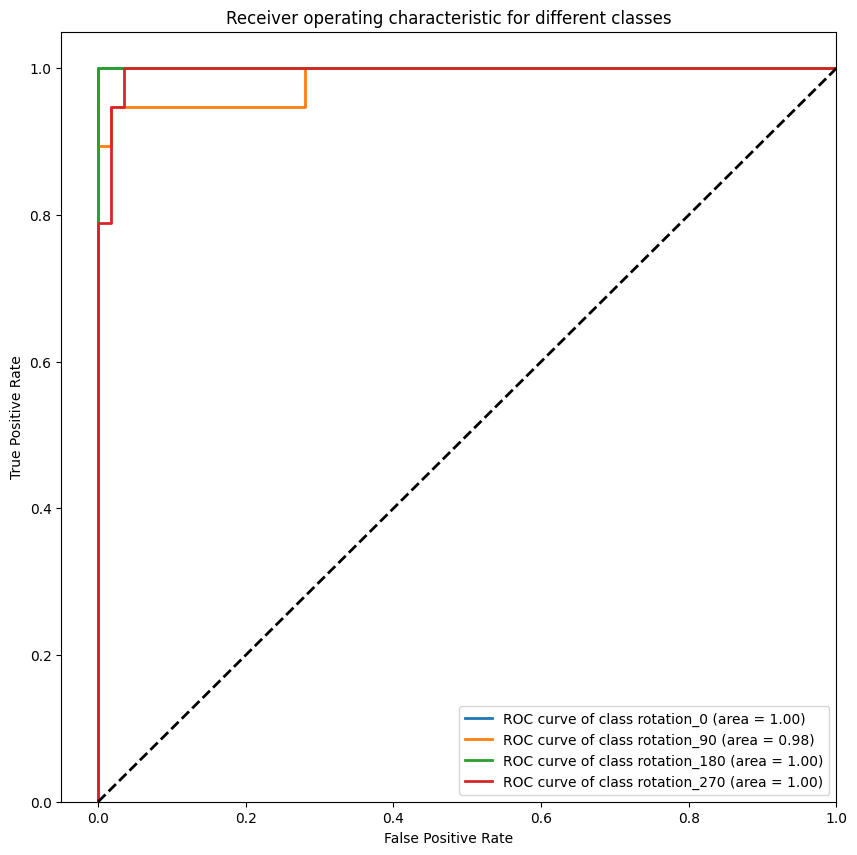

In [49]:
fig, ax = plt.subplots(figsize=(10,10))
fpr = dict()
tpr = dict()
roc_auc = dict()
classes = list(CLASSES.values())
labels = list(CLASSES.keys())
label_test = label_binarize(result[0], classes=classes)
n_classes = label_test.shape[1]
y_score = result[2]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for different classes')
plt.legend(loc="lower right")
plt.show()

Как мы можем видеть из графика выше, и что подтверждает вышесказанное, полученная модель хорошо предсказывает классы "rotation_0" и "rotation_270": площадь под ROC-кривой AUC=1. Немного неожиданно, что AUC=1 и для класса "rotation_180", ведь мы видели одну ошибку в определении данного класса. И вполне ожидаемо самое низкое значение площади под ROC-кривой у класса "rotation_90": этот класс модель определяет не так эффективно, как другие.

Сохраним веса выбранной модели для дальнейшего использования их в внутри микросервиса.

In [50]:
outPath = '/content/drive/My Drive/DonorSearch/result/'
outPath

'/content/drive/My Drive/DonorSearch/result/'

In [51]:
torch.save(inception_2.state_dict(), outPath + 'Inception_img_orientation.pth')

## Выводы

Перед нами стояла задача разработки модели компьютерного зрения, которая бы определяла ориентацию медицинских справо по форме 405 для дальнейшего их разворота в нормальной ориентации. Заказчик хочет встроить эту модель в свое приложение для разворота справок перед процессом распознавания текста на этих с правках с помощью OCR.

**Исследование существующих подходов**

Перед тем, как приступить непостредственно к анализу и обработке данных от заказчика и созданию модели, мы провели анализ современных подходов к решению данной задачи и выяснили, что для определения ориентации изображений существуют следующие методы:
1.  Традиционные методы компьютерного зрения: эти методы обычно используют классические алгоритмы для анализа изображения и определения его ориентации (например, Hough Transform, Tesseract OSD);
2. Методы на основе глубокого обучения (Deep Learning): эти методы более мощные и гибкие, особенно для сложных и зашумленных изображений (например, сверточные нейронные сети, создание новых или использование готовых архитектур).
3. Комбинация традиционных методов и методов на основе глубокого обучения.

В нашем исследовании мы решили применить методы на основе глубокого обучения, а именно использовать сверточную нейронную сеть готовой архитектуры.

**Анализ и подготовка данных**

Мы проанализировали предоставленный нам датасет изображений от заказчика и пришли к следующим заключениям:
1. В изначальном датасете заказчика было 173 изображения. Такого количества изображений недостаточно для обучения модели. Мы решили увеличить датасет с помощью добавления похожих изображений и аугментаций.
2. В изначальном датасете отсутствовала разметка ориентации изображений. При этом большая часть изображений имела нормальную ориентацию (0 градусов), лишь малая часть изображений имела иную ориентацию. Исходя из этого, разметку изображений необходимо было провести своими силами.

Для целей увеличения объема данных мы:
- нашли на Kaggle датасет медицинских справок на иностранном языке, которые имели похожее справкам 405 содержание в части объектов (таблицы, печатный и рукописный текст, печати). Также изображения в найденном датасете были сфотографированны на различных поверхностях, рядом с другими объектами, включали в себя руки фотографирующих, т.е. были очень похожи на то, что как мы ожидаем подгружают в приложение заказчика пользователи.
- решили применить наиболее естественные с нашей точки зрения изменения к изображениям, чтобы увеличить датасет и сохранить распознаваемость классов. В итоге мы остановились на небольшом изменении перспективы и небольшом повороте изображения в диапазоне (-5, 5) градусов.

Для разметки изображений мы выполнили следующее:
- развернули все изображения исходного датасета в ориентации 0° (изображения из датасета, которым мы обогощали исходный датасет были изначально корректно ориентированы);
- объединили исходный датасет и датасет медицинских справок с Kaggle в один;
- с помощью написанного нами скрипта осуществили разделение датасета на подпапки, где каждая сооответствовала одному из 4 классов ('rotation_0', 'rotation_90', 'rotation_180', 'rotation_270'), с одновременным разворотом изображений на угол, соответствующий названию папки. В итоге мы получили по 88 изображений каждого класса.
- с помощью другого скрипта мы разделили полученный датасет на тренировочную, валидационную и тестовую выборки в соотношении 0.6, 0.2, 0.2 таким образом, чтобы в каждом из типов выборок содержалось одинаковое количество объектов каждого класса.

В итоге мы получили тренировочную, валидационную и тестовую выборки с равным количеством объектов в каждом классе.

Далее мы создали трансформеры для аугментации изображений с искажением перспективы и небольшим поворотом, c помощью которых нам удалось увеличить количество изображений в тренировочной и валидационной выборке в 3 раза.

**Обучение моделей и выбор лучшей модели**

Как было сказано выше, мы решили использовать сверточные нейронные сети (CNN) готовой архитектуры. Мы провели обучение следующего набора моделей:
- ResNet18: CNN глубиной 18 слоев с заменной числа классов на нужные нам 4 в fc слое;
- ResNet50: CNN глубиной 50 слоев с заменной числа классов на нужные нам 4 в fc слое и заморозкой последних нескольких слоев;
- Inception: CNN, которая создает параллельные ветки слоев с заменой числа классов в fc слое и слое логитов на 4 нужные нам класса.

Наилучшей моделью оказалась модель Inception, которую мы обучили на 3 эпохах. Данная модель показала значение выбранной нами метрики accuracy на тренировочной выборке, равное 1, на валидационной выборке - 0.985, на тестовой выборке  - 0.96.

Выбранная нами модель иделально справляется с предсказанием ориентации изображений 0° и 270°, чуть хуже с предсказанием изображений с ориентацией 180° (допущена 1 ошибка на тестовой выборке из 76 объектов) и 90°(допущено 2 ошибки на тестовой выборке из 76 объектов).